In [45]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X_train = pd.read_csv("../Data/Processed/X_train.csv")
X_test  = pd.read_csv("../Data/Processed/X_test.csv")
# squeeze  making them a series/1D
y_train = pd.read_csv("../Data/Processed/y_train.csv").squeeze()
y_test  = pd.read_csv("../Data/Processed/y_test.csv").squeeze()



X = X_train
y = y_train

numeric_cols = [
    "Administrative", "Informational","ProductRelated", "Administrative_Duration", "Informational_Duration", "ProductRelated_Duration","BounceRates","ExitRates","SpecialDay",
]

# Fit the scaler on training numerics only then replace those columns in X
scaler = StandardScaler()
X[numeric_cols] = pd.DataFrame(
    scaler.fit_transform(X[numeric_cols]),
    columns=numeric_cols,
    index=X.index
).astype(float)


# class weight balanced counters the class imbalance (giving buyer errors more weight)
logr = LogisticRegression(class_weight='balanced', max_iter=200, random_state=42)
logr.fit(X, y)



LogisticRegression(class_weight='balanced', max_iter=200, random_state=42)


Threshold comparison on CV predictions (Training Set):
Threshold 0.10: Precision=0.179, Recall=0.995, F1=0.303
Threshold 0.15: Precision=0.185, Recall=0.988, F1=0.311
Threshold 0.20: Precision=0.192, Recall=0.976, F1=0.321
Threshold 0.25: Precision=0.200, Recall=0.965, F1=0.331
Threshold 0.30: Precision=0.209, Recall=0.943, F1=0.342
Threshold 0.35: Precision=0.219, Recall=0.914, F1=0.353
Threshold 0.40: Precision=0.232, Recall=0.881, F1=0.367
Threshold 0.45: Precision=0.244, Recall=0.824, F1=0.376
Threshold 0.50: Precision=0.261, Recall=0.762, F1=0.389
Threshold 0.55: Precision=0.278, Recall=0.667, F1=0.393
Threshold 0.60: Precision=0.297, Recall=0.552, F1=0.386
Threshold 0.65: Precision=0.320, Recall=0.423, F1=0.365
Threshold 0.70: Precision=0.337, Recall=0.270, F1=0.300
Threshold 0.75: Precision=0.353, Recall=0.140, F1=0.201
Threshold 0.80: Precision=0.366, Recall=0.056, F1=0.098
Threshold 0.85: Precision=0.351, Recall=0.017, F1=0.033

>>> Best threshold (by F1 on CV): 0.55 with F1=

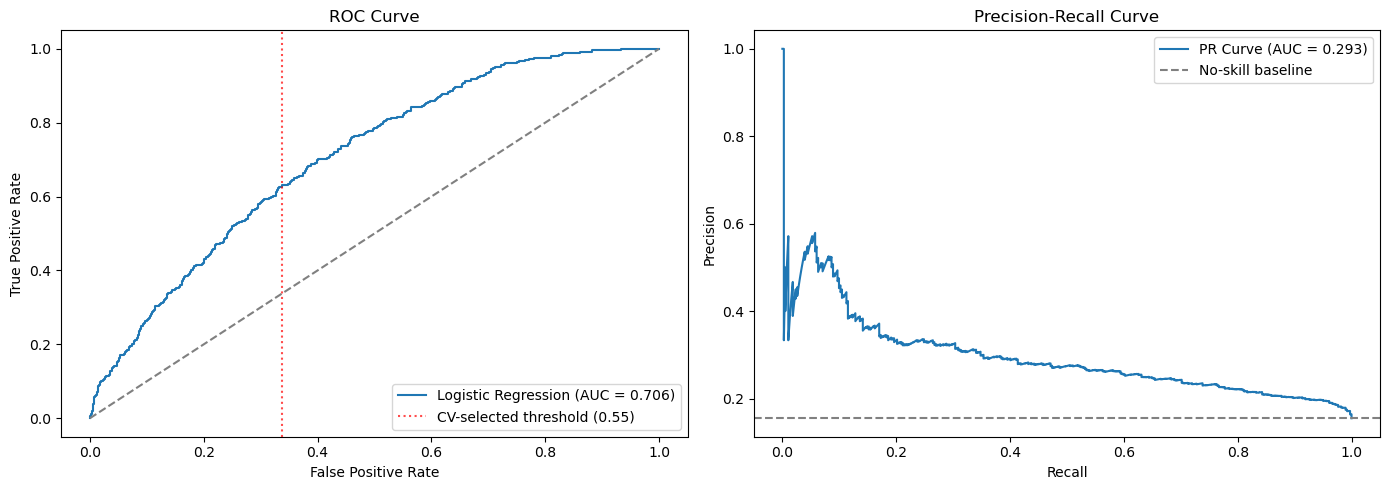

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
# Get cross-validated probability predictions on training set
y_proba_cv = cross_val_predict(logr, X, y, cv=5, method='predict_proba')[:, 1]

# Find optimal threshold using cross-validated predictions
thresholds = np.arange(0.1, 0.9, 0.05)
best_threshold = 0.5
best_f1 = 0

print("\nThreshold comparison on CV predictions (Training Set):")
for t in thresholds:
    preds_t = (y_proba_cv >= t).astype(int)
    precision = precision_score(y, preds_t)
    recall = recall_score(y, preds_t)
    f1 = f1_score(y, preds_t)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t
    
    print(f"Threshold {t:.2f}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

print(f"\n>>> Best threshold (by F1 on CV): {best_threshold:.2f} with F1={best_f1:.3f}")


# Scale test set using the same scaler (transform only, no fit)
X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = pd.DataFrame(
    scaler.transform(X_test[numeric_cols]),
    columns=numeric_cols,
    index=X_test.index
).astype(float)

# Get predictions on test set
y_proba_test = logr.predict_proba(X_test_scaled)[:, 1]

# Apply the CV-selected threshold
y_pred_optimal = (y_proba_test >= best_threshold).astype(int)

# Also show default threshold for comparison
y_pred_default = (y_proba_test >= 0.5).astype(int)

print(f"\nResults with DEFAULT threshold (0.50):")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_default))
print("\nClassification report:\n", classification_report(y_test, y_pred_default, digits=3))

print(f"\nResults with CV-SELECTED threshold ({best_threshold:.2f}):")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_optimal))
print("\nClassification report:\n", classification_report(y_test, y_pred_optimal, digits=3))

print(f"\nROC-AUC (threshold-independent): {roc_auc_score(y_test, y_proba_test):.3f}")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_test)
axes[0].plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_test):.3f})")
axes[0].plot([0, 1], [0, 1], linestyle="--", color="grey")
axes[0].axvline(x=fpr[np.argmin(np.abs(roc_thresholds - best_threshold))], 
                color='red', linestyle=':', alpha=0.7, label=f'CV-selected threshold ({best_threshold:.2f})')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend()

# Precision-Recall Curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_proba_test)
axes[1].plot(recall_curve, precision_curve, label=f"PR Curve (AUC = {auc(recall_curve, precision_curve):.3f})")
axes[1].axhline(y=y_test.mean(), linestyle="--", color="grey", label="No-skill baseline")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)


pr_auc_logreg = auc(recall, precision)

print(f"Logistic Regression PR-AUC: {pr_auc_logreg:.3f}")

Logistic Regression PR-AUC: 0.293
